<a href="https://colab.research.google.com/github/venkatesh-manikumar/Datascience-Assignments/blob/main/Predict_The_Flight_Ticket_Price_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [788]:
from google.colab import drive
##drive.mount('/content/drive')

In [789]:
import pandas as pd
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder , OneHotEncoder , LabelBinarizer
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [790]:
train_data = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Data_Train.xlsx')
test_data_sample  = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Test_set.xlsx')
test_data_sample['Price'] = train_data.Price.median()

train_data = pd.concat([train_data,test_data_sample])

In [791]:
train_data.shape

(13354, 11)

In [792]:
train_data.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

In [793]:
train_data.drop_duplicates(inplace=True)
train_data.shape

(13108, 11)

Missing data stats

In [794]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [795]:
train_data[train_data['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480.0


In [796]:
train_data[train_data['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480.0


In [797]:
train_data.dropna(inplace=True)
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [798]:
train_data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


Feature Engineering

In [799]:
train_data['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [800]:
train_data['Journey_date'] = pd.to_datetime(train_data['Date_of_Journey'],dayfirst=True)
#train_data['Day'] =train_data['Journey_date'].apply(lambda x:x.day_name())
train_data['Day_of_week'] =train_data['Journey_date'].apply(lambda x:x.isoweekday())

train_data.drop(['Date_of_Journey'],axis=1,inplace=True)

train_data.dtypes

Airline                    object
Source                     object
Destination                object
Route                      object
Dep_Time                   object
Arrival_Time               object
Duration                   object
Total_Stops                object
Additional_Info            object
Price                     float64
Journey_date       datetime64[ns]
Day_of_week                 int64
dtype: object

In [801]:
train_data.head(5)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Day_of_week
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,2019-03-24,7
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,2019-05-01,3
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,2019-06-09,7
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,2019-05-12,7
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,2019-03-01,5


In [802]:
India_holidays = holidays.India()
train_data['isHoliday'] =train_data['Journey_date'].apply(lambda x: 1 if x in India_holidays else 0)


In [803]:
for i in range(1,train_data['Route'].str.count("→").max()+1):
  column_name = "Route_"+str(i)
  train_data[column_name]= train_data['Route'].str.split('→ ').str[i]
  train_data[column_name].fillna('None',inplace=True)

train_data.drop(['Route'],axis=1,inplace=True)
train_data.drop(['Journey_date'],axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,7,0,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662.0,3,1,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,7,1,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218.0,7,0,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302.0,5,0,NAG,DEL,None,None,None


In [804]:
train_data.Total_Stops.value_counts()

1 stop      7052
non-stop    4321
2 stops     1678
3 stops       54
4 stops        2
Name: Total_Stops, dtype: int64

In [805]:
train_data['Total_Stops'] = train_data.Total_Stops.str.split(" ").str[0]
train_data['Total_Stops'] = train_data['Total_Stops'].replace('non-stop','0')
train_data['Total_Stops'] = train_data['Total_Stops'].astype(int)

train_data.head()


,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,0,No info,3897.0,7,0,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,05:50,13:15,7h 25m,2,No info,7662.0,3,1,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,19h,2,No info,13882.0,7,1,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,18:05,23:30,5h 25m,1,No info,6218.0,7,0,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,16:50,21:35,4h 45m,1,No info,13302.0,5,0,NAG,DEL,None,None,None


<Axes: xlabel='Additional_Info'>

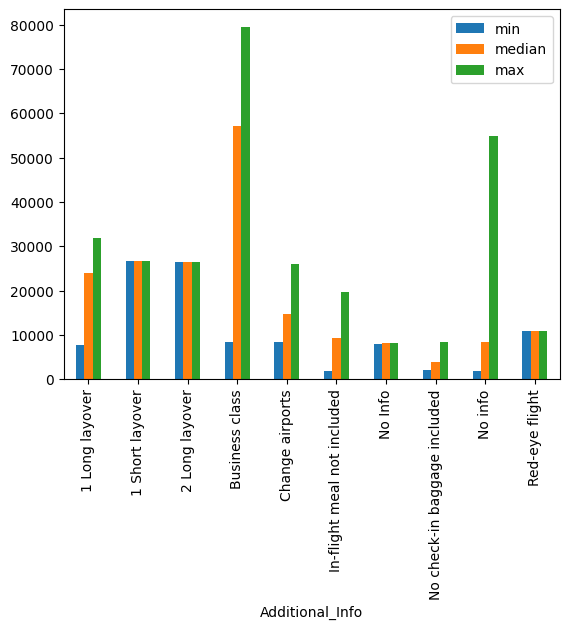

In [806]:
train_data.Additional_Info.unique()
train_data.groupby('Additional_Info')['Price'].aggregate(['min','median','max']).plot(kind='bar')


In [807]:
train_data.Additional_Info.value_counts()

No info                         10308
In-flight meal not included      2366
No check-in baggage included      394
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
1 Short layover                     1
Red-eye flight                      1
2 Long layover                      1
Name: Additional_Info, dtype: int64

In [808]:
np.sort(train_data.Dep_Time.str.split(':').str[0].astype(int).unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [809]:
train_data['Dep_hour'] = train_data.Dep_Time.str.split(':').str[0].astype(int)
train_data['Dep_minutes'] = train_data.Dep_Time.str.split(':').str[1].astype(int)

train_data.drop(['Dep_Time'],axis=1,inplace=True)

In [810]:
train_data.head()

,Airline,Source,Destination,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minutes
0,IndiGo,Banglore,New Delhi,01:10 22 Mar,2h 50m,0,No info,3897.0,7,0,DEL,None,None,None,None,22,20
1,Air India,Kolkata,Banglore,13:15,7h 25m,2,No info,7662.0,3,1,IXR,BBI,BLR,None,None,5,50
2,Jet Airways,Delhi,Cochin,04:25 10 Jun,19h,2,No info,13882.0,7,1,LKO,BOM,COK,None,None,9,25
3,IndiGo,Kolkata,Banglore,23:30,5h 25m,1,No info,6218.0,7,0,NAG,BLR,None,None,None,18,5
4,IndiGo,Banglore,New Delhi,21:35,4h 45m,1,No info,13302.0,5,0,NAG,DEL,None,None,None,16,50


In [811]:
train_data['Arrival_hour'] = train_data.Arrival_Time.str.split(':').str[0].astype(int)
train_data['Arrival_minutes'] = train_data.Arrival_Time.str.split(':').str[1].str.split(' ').str[0].astype(int)

train_data.drop(['Arrival_Time'],axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes
0,IndiGo,Banglore,New Delhi,2h 50m,0,No info,3897.0,7,0,DEL,None,None,None,None,22,20,1,10
1,Air India,Kolkata,Banglore,7h 25m,2,No info,7662.0,3,1,IXR,BBI,BLR,None,None,5,50,13,15
2,Jet Airways,Delhi,Cochin,19h,2,No info,13882.0,7,1,LKO,BOM,COK,None,None,9,25,4,25
3,IndiGo,Kolkata,Banglore,5h 25m,1,No info,6218.0,7,0,NAG,BLR,None,None,None,18,5,23,30
4,IndiGo,Banglore,New Delhi,4h 45m,1,No info,13302.0,5,0,NAG,DEL,None,None,None,16,50,21,35


In [812]:
train_data['Duration_hour']  = train_data.Duration.str.split(' ').str[0].str.split('h').str[0].str.split('m').str[0].astype(int)
train_data['Duration_minutes']  = train_data.Duration.str.split(' ').str[1].fillna('0m').str.split('m').str[0].astype(int)
train_data['Total_Duration'] = train_data['Duration_hour'] *60 + train_data['Duration_minutes']


train_data.drop(['Duration'],axis=1,inplace=True)
train_data.drop(['Duration_hour'],axis=1,inplace=True)
train_data.drop(['Duration_minutes'],axis=1,inplace=True)



#train_data['Duration_minutes'].str.contains('m').value_counts()

#train_data[train_data.Duration.str.split(' ').str[0].str.split('h').str[0] == '5m']

In [813]:
train_data.head()


,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes,Total_Duration
0,IndiGo,Banglore,New Delhi,0,No info,3897.0,7,0,DEL,None,None,None,None,22,20,1,10,170
1,Air India,Kolkata,Banglore,2,No info,7662.0,3,1,IXR,BBI,BLR,None,None,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,2,No info,13882.0,7,1,LKO,BOM,COK,None,None,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,1,No info,6218.0,7,0,NAG,BLR,None,None,None,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,1,No info,13302.0,5,0,NAG,DEL,None,None,None,16,50,21,35,285


In [814]:
#one_hot_encoded_data = pd.get_dummies(train_data, columns = ['Airline','Airline'])
#one_hot_encoded_data

#enc = OneHotEncoder()
#enc_data = pd.DataFrame(enc.fit_transform(train_data[['Airline', 'Additional_Info']]).toarray())
#one_hot_encoded_data = train_data.join(enc_data)

#one_hot_encoded_data.head()


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
result = ohe.fit_transform(train_data[['Airline', 'Additional_Info']])

one_hot_encoded_data = pd.DataFrame(result, columns=['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet',
       'Vistara', 'Vistara Premium economy','1 Long layover', '1 Short layover', '2 Long layover',
       'Business class', 'Change airports', 'In-flight meal not included',
       'No Info', 'No check-in baggage included', 'No info',
       'Red-eye flight'])

one_hot_encoded_data = train_data.join(one_hot_encoded_data)
one_hot_encoded_data.drop(['Airline','Additional_Info'],axis=1,inplace=True)
#print(ohe.categories_)
one_hot_encoded_data[1:2]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Source,Destination,Total_Stops,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,...,1 Long layover,1 Short layover,2 Long layover,Business class,Change airports,In-flight meal not included,No Info,No check-in baggage included,No info,Red-eye flight
0,Delhi,Cochin,1,8372.0,4,0,BOM,COK,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [815]:
one_hot_encoded_data.head(5)

,Source,Destination,Total_Stops,Price,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,...,1 Long layover,1 Short layover,2 Long layover,Business class,Change airports,In-flight meal not included,No Info,No check-in baggage included,No info,Red-eye flight
0,Banglore,New Delhi,0,3897.0,7,0,DEL,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,Delhi,Cochin,1,8372.0,4,0,BOM,COK,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Kolkata,Banglore,2,7662.0,3,1,IXR,BBI,BLR,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Kolkata,Banglore,1,8372.0,7,0,MAA,BLR,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Delhi,Cochin,2,13882.0,7,1,LKO,BOM,COK,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [816]:
def tranform_data(df,col_name):
    encoder_name = LabelEncoder()
    print(col_name)
    flight_cat = df[col_name]
    flight_cat_encoded = encoder_name.fit_transform(flight_cat)
    encoder_col_name = col_name +"_encoded"
    df_temp = pd.DataFrame(flight_cat_encoded,columns=[encoder_col_name])
    left = df_temp.reset_index()
    right = df.reset_index()
    result = pd.merge(left, right, on=["index","index"])
    result.drop(['index'],axis=1,inplace=True)

    return result


df1 = tranform_data(one_hot_encoded_data,'Source')
df2 = tranform_data(df1,'Destination')
df3 = tranform_data(df2,'Route_1')
df4 = tranform_data(df3,'Route_2')
df5 = tranform_data(df4,'Route_3')
df6 = tranform_data(df4,'Route_4')
df7 = tranform_data(df4,'Route_5')

df7.drop(['Source','Destination','Route_1','Route_2','Route_3','Route_4','Route_5'],axis=1,inplace=True)

train_data = df7.copy()

Source
Destination
Route_1
Route_2
Route_3
Route_4
Route_5


In [825]:
train_data.columns

Index(['Route_5_encoded', 'Route_2_encoded', 'Route_1_encoded',
       'Destination_encoded', 'Source_encoded', 'Total_Stops', 'Price',
       'Day_of_week', 'isHoliday', 'Dep_hour', 'Dep_minutes', 'Arrival_hour',
       'Arrival_minutes', 'Total_Duration', 'Air Asia', 'Air India', 'GoAir',
       'IndiGo', 'Jet Airways', 'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', '1 Long layover', '1 Short layover',
       '2 Long layover', 'Business class', 'Change airports',
       'In-flight meal not included', 'No Info',
       'No check-in baggage included', 'No info', 'Red-eye flight'],
      dtype='object')

<Axes: >

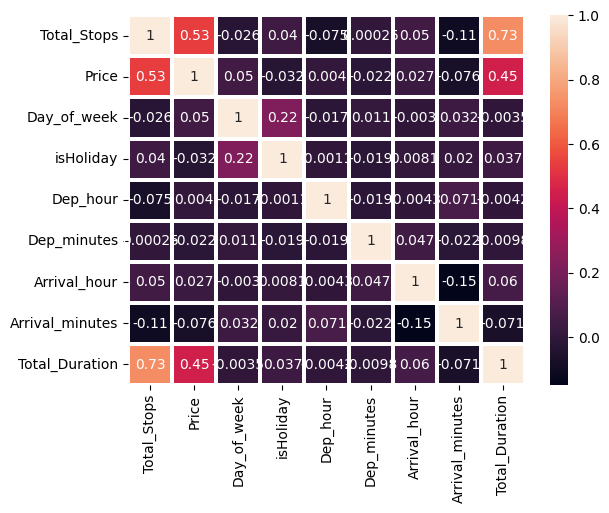

In [835]:
sns.heatmap(train_data[[
        'Total_Stops', 'Price',
       'Day_of_week', 'isHoliday', 'Dep_hour', 'Dep_minutes', 'Arrival_hour',
       'Arrival_minutes', 'Total_Duration']].corr(), linewidth=1.5,annot=True)

In [736]:
lin_reg = LinearRegression()
train_labels = train_data['Price'].copy()
train= train_data.drop(columns = ['Price'],axis=1)
lin_reg.fit(train,train_labels)

LinearRegression()

In [756]:
lin_reg.intercept_ , lin_reg.coef_

(956.9248532991542,
 array([ 6.92741528e+03, -1.27205554e+02, -7.78903593e+01,  5.33430794e+02,
         2.47081334e+01,  2.22697881e+03,  1.59620666e+02, -9.23709718e+02,
         2.30369849e+01, -4.63854631e+00, -4.66566957e+00,  2.46892614e+00,
         5.47063532e-01, -7.43696406e+02, -1.17430696e+03, -1.12365795e+03,
        -1.17322615e+03, -8.67142903e+02,  8.12107546e+03, -8.25793329e+02,
        -6.62752965e+02, -1.13868679e+03, -9.36985145e+02, -1.13702613e+03,
         1.66219927e+03,  8.92558047e+02,  4.70500899e+02,  3.02989570e+02,
        -4.31953363e+03,  1.33555141e+03,  5.40436171e+02,  5.64205076e+02,
         7.26311951e+02,  8.22499719e+02, -1.33551921e+03]))

In [737]:
test_data = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Test_set.xlsx')

In [738]:
test_data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [739]:
test_data.shape

(2671, 10)

In [740]:
test_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [741]:
test_data['Journey_date'] = pd.to_datetime(test_data['Date_of_Journey'],dayfirst=True)
#train_data['Day'] =train_data['Journey_date'].apply(lambda x:x.day_name())
test_data['Day_of_week'] =test_data['Journey_date'].apply(lambda x:x.isoweekday())

test_data.drop(['Date_of_Journey'],axis=1,inplace=True)

test_data.dtypes

Airline                    object
Source                     object
Destination                object
Route                      object
Dep_Time                   object
Arrival_Time               object
Duration                   object
Total_Stops                object
Additional_Info            object
Journey_date       datetime64[ns]
Day_of_week                 int64
dtype: object

In [742]:
India_holidays = holidays.India()
test_data['isHoliday'] =test_data['Journey_date'].apply(lambda x: 1 if x in India_holidays else 0)

In [743]:
for i in range(1,test_data['Route'].str.count("→").max()+1):
  column_name = "Route_"+str(i)
  test_data[column_name]= test_data['Route'].str.split('→ ').str[i]
  test_data[column_name].fillna('None',inplace=True)

test_data.drop(['Route'],axis=1,inplace=True)
test_data.drop(['Journey_date'],axis=1,inplace=True)

In [744]:
test_data['Total_Stops'] = test_data.Total_Stops.str.split(' ').str[0]
test_data['Total_Stops'] = test_data['Total_Stops'].replace('non-stop','0')
test_data['Total_Stops'] = test_data['Total_Stops'].astype(int)

test_data[test_data['Total_Stops'].isna()]

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5


In [745]:
test_data['Dep_hour'] = test_data.Dep_Time.str.split(':').str[0].astype(int)
test_data['Dep_minutes'] = test_data.Dep_Time.str.split(':').str[1].astype(int)




test_data.drop(['Dep_Time'],axis=1,inplace=True)

In [746]:
test_data['Arrival_hour'] = test_data.Arrival_Time.str.split(':').str[0].astype(int)
test_data['Arrival_minutes'] = test_data.Arrival_Time.str.split(':').str[1].str.split(' ').str[0].astype(int)

test_data.drop(['Arrival_Time'],axis=1,inplace=True)

In [747]:
test_data['Duration_hour']  = test_data.Duration.str.split(' ').str[0].str.split('h').str[0].str.split('m').str[0].astype(int)
test_data['Duration_minutes']  = test_data.Duration.str.split(' ').str[1].fillna('0m').str.split('m').str[0].astype(int)
test_data['Total_Duration'] = test_data['Duration_hour'] *60 + test_data['Duration_minutes']


test_data.drop(['Duration'],axis=1,inplace=True)
test_data.drop(['Duration_hour'],axis=1,inplace=True)
test_data.drop(['Duration_minutes'],axis=1,inplace=True)

test_data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes,Total_Duration
0,Jet Airways,Delhi,Cochin,1,No info,4,0,BOM,COK,None,None,None,17,30,4,25,655
1,IndiGo,Kolkata,Banglore,1,No info,7,0,MAA,BLR,None,None,None,6,20,10,20,240
2,Jet Airways,Delhi,Cochin,1,In-flight meal not included,2,0,BOM,COK,None,None,None,19,15,19,0,1425
3,Multiple carriers,Delhi,Cochin,1,No info,2,0,BOM,COK,None,None,None,8,0,21,0,780
4,Air Asia,Banglore,Delhi,0,No info,1,0,DEL,None,None,None,None,23,55,2,45,170


In [748]:
#one_hot_encoded_data = pd.get_dummies(test_data, columns = ['Airline','Additional_Info'])
#one_hot_encoded_data

result = ohe.transform(test_data[['Airline', 'Additional_Info']])

one_hot_encoded_data = pd.DataFrame(result, columns=['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet',
       'Vistara', 'Vistara Premium economy','1 Long layover', '1 Short layover', '2 Long layover',
       'Business class', 'Change airports', 'In-flight meal not included',
       'No Info', 'No check-in baggage included', 'No info',
       'Red-eye flight'])

one_hot_encoded_data = test_data.join(one_hot_encoded_data)
one_hot_encoded_data.drop(['Airline','Additional_Info'],axis=1,inplace=True)
#print(ohe.categories_)
one_hot_encoded_data[1:2]

,Source,Destination,Total_Stops,Day_of_week,isHoliday,Route_1,Route_2,Route_3,Route_4,Route_5,...,1 Long layover,1 Short layover,2 Long layover,Business class,Change airports,In-flight meal not included,No Info,No check-in baggage included,No info,Red-eye flight
1,Kolkata,Banglore,1,7,0,MAA,BLR,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [749]:
def tranform_data(df,col_name):
    encoder_name= LabelEncoder()
    flight_cat = df[col_name]
    flight_cat_encoded = encoder_name.fit_transform(flight_cat)
    encoder_col_name = col_name +"_encoded"
    df_temp = pd.DataFrame(flight_cat_encoded,columns=[encoder_col_name])
    left = df_temp.reset_index()
    right = df.reset_index()
    result = pd.merge(left, right, on=["index","index"])
    result.drop(['index'],axis=1,inplace=True)

    return result


df1 = tranform_data(one_hot_encoded_data,'Source')
df2 = tranform_data(df1,'Destination')
df3 = tranform_data(df2,'Route_1')
df4 = tranform_data(df3,'Route_2')
df5 = tranform_data(df4,'Route_3')
df6 = tranform_data(df4,'Route_4')
df7 = tranform_data(df4,'Route_5')

df7.drop(['Source','Destination','Route_1','Route_2','Route_3','Route_4','Route_5'],axis=1,inplace=True)

test_data = df7.copy()
test_data.head(5)

,Route_5_encoded,Route_2_encoded,Route_1_encoded,Destination_encoded,Source_encoded,Total_Stops,Day_of_week,isHoliday,Dep_hour,Dep_minutes,...,1 Long layover,1 Short layover,2 Long layover,Business class,Change airports,In-flight meal not included,No Info,No check-in baggage included,No info,Red-eye flight
0,1,5,7,1,2,1,4,0,17,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,3,29,0,3,1,7,0,6,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5,7,1,2,1,2,0,19,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,5,7,1,2,1,2,0,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,21,13,2,0,0,1,0,23,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [750]:
DF = pd.DataFrame(lin_reg.predict(test_data))
DF.to_csv("/content/drive/MyDrive/DataScience/Flight_price_prediction/result_linear_regression.csv",index=False,header=['Price'])

In [751]:
poly_features = PolynomialFeatures(degree =2 )
x_poly = poly_features.fit_transform(train_data.drop(columns = ['Price'],axis=1))


In [752]:
lin_reg_poly = LinearRegression()
train_labels = train_data['Price'].copy()
train= train_data.drop(columns = ['Price'],axis=1)
lin_reg_poly.fit(x_poly,train_labels)

LinearRegression()

In [753]:
x_poly_test = poly_features.transform(test_data)

In [754]:
DF_poly = pd.DataFrame(lin_reg_poly.predict(x_poly_test))
DF_poly.to_csv("/content/drive/MyDrive/DataScience/Flight_price_prediction/result_PolynomialFeatures.csv",index=False,header=['Price'])
